## Dirichlet model training

In [1]:
!nvidia-smi

Wed Aug 23 07:54:58 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.26                 Driver Version: 375.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:02:00.0     Off |                  N/A |
| 25%   51C    P2    44W / 200W |   1288MiB /  8113MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:03:00.0     Off |                  N/A |
|  0%   48C    P2    44W / 200W |   7937MiB /  8112MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

sys.path.append(os.path.join("..", "..", ".."))
import ecg.dataset as ds
from ecg.batch import ModelEcgBatch
from ecg.models.metrics import classification_report

Using TensorFlow backend.


### TF config

In [3]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [4]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth=True

### Dataset initialization

In [5]:
index = ds.FilesIndex(path="/notebooks/data/ECG/training2017/*.hea", no_ext=True, sort=True)
eds = ds.Dataset(index, batch_class=ModelEcgBatch)
eds.cv_split(0.8)

### Training pipeline

In [6]:
N_EPOCH = 500
BATCH_SIZE = 100
PREFETCH = 10

In [7]:
train_ppl = (eds.train.pipeline()
                .load(fmt="wfdb", components=["signal", "meta"])
                .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv", fmt="csv", components="target")
                .drop_labels(["~"])
                .replace_labels({"N": "NO", "O": "NO"})
                .flip_signals()
                .random_resample_signals("normal", loc=300, scale=10)
                .random_segment_signals(2048, {"A": 9, "NO": 3})
                .binarize_labels()
                .train_on_batch("dirichlet", loss_var_name="loss_list")
                .run(batch_size=BATCH_SIZE, shuffle=True, drop_last=True, n_epochs=N_EPOCH, prefetch=PREFETCH))

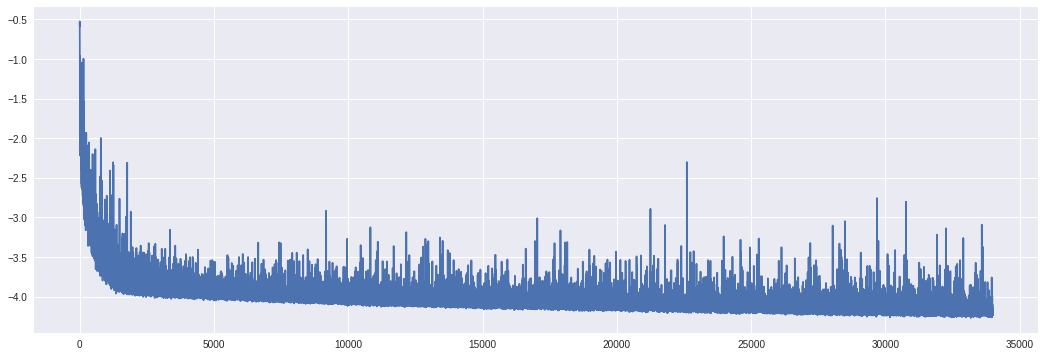

In [8]:
fig = plt.figure(figsize=(18, 6))
plt.plot(train_ppl.get_variable("loss_list"))
plt.show()

In [9]:
train_ppl.get_model_by_name("dirichlet").save("/notebooks/Kuvaev/dirichlet/dirichlet")

### Testing pipeline

In [10]:
BATCH_SIZE = 100

In [11]:
test_ppl = (eds.test.pipeline()
               .import_model("dirichlet", train_ppl)
               .load(fmt="wfdb", components=["signal", "meta"])
               .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv", fmt="csv", components="target")
               .drop_labels(["~"])
               .replace_labels({"N": "NO", "O": "NO"})
               .flip_signals()
               .segment_signals(2048, 512)
               .binarize_labels()
               .predict_on_batch("dirichlet", predictions_var_name="predictions_list")
               .run(batch_size=BATCH_SIZE, shuffle=False, drop_last=False, n_epochs=1))

In [12]:
print(classification_report(test_ppl.get_variable("predictions_list")))

             precision    recall  f1-score   support

          A       0.87      0.80      0.83       171
         NO       0.98      0.99      0.98      1484

avg / total       0.97      0.97      0.97      1655



### Predicting pipeline

In [13]:
BATCH_SIZE = 100

In [14]:
model_path = "/notebooks/Kuvaev/dirichlet/"
last_model_path = tf.train.latest_checkpoint(model_path)
model_config = {
    "graph_path": last_model_path + ".meta",
    "checkpoint_path": last_model_path,
    "classes_path": last_model_path + ".dill"
}
config = {"dirichlet_pretrained": model_config}

In [15]:
ppl = (ds.Pipeline(config=config)
         .init_model("dirichlet_pretrained")
         .load(fmt="wfdb", components=["signal", "meta"])
         .flip_signals()
         .segment_signals(2048, 512)
         .predict_on_batch("dirichlet_pretrained", predictions_var_name="predictions_list")
         .run(batch_size=BATCH_SIZE, shuffle=False, drop_last=False, n_epochs=1, lazy=True))

In [16]:
file_path = "/notebooks/data/ECG/training2017/A00001.hea"
index = ds.FilesIndex(path=file_path, no_ext=True, sort=True)
predict_eds = ds.Dataset(index, batch_class=ModelEcgBatch)

In [17]:
(predict_eds >> ppl).run()

In [18]:
ppl.get_variable("predictions_list")

[{'target_pred': {'A': 0.020612195, 'NO': 0.97938776},
  'uncertainty': 0.0070605278015136719}]